# Naive neural network

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os

# Set the default font size for text elements (e.g., titles, labels)
sns.set() # default from sns is pretties (:
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['font.family'] = 'sans-serif'


# Set filename start. Create the folder if gone
filepath_location = "Figures/b/"
if not os.path.exists(filepath_location):
    os.makedirs(filepath_location[0:-1])

inputs = (n_inputs, pixel_width, pixel_height, depth) = (1797, 8, 8, 1)
labels = (n_inputs) = (1797,)


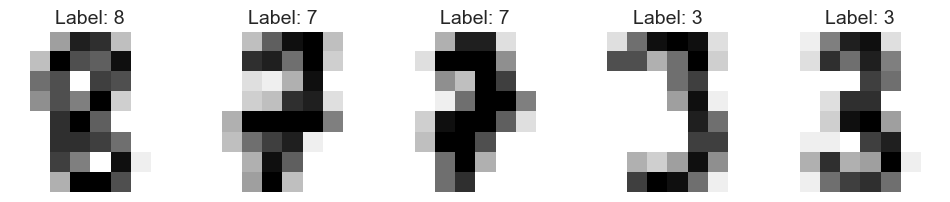

In [11]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# ensure the same random numbers appear every time
np.random.seed(0)

# display images in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,12)


# download MNIST dataset
digits = datasets.load_digits()

# define inputs and labels
inputs = digits.images
labels = digits.target

# RGB images have a depth of 3
# our images are grayscale so they should have a depth of 1
inputs = inputs[:,:,:,np.newaxis]

print("inputs = (n_inputs, pixel_width, pixel_height, depth) = " + str(inputs.shape))
print("labels = (n_inputs) = " + str(labels.shape))


# choose some random images to display
n_inputs = len(inputs)
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Label: %d" % digits.target[random_indices[i]])
plt.show()

### Training the neural network

In [12]:
# Handling paths for importing code
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

# Import split and MSELoss. All descent methods.
from Code.utilities import train_test_split, MSELoss_method, plot_test_results, ridge_loss_method
from Code.neural_network import _beta_init, get_neural_network_model
from Code.descent_methods import SGD_adam

from jax import jit, nn, grad, device_get
import jax.numpy as jnp

In [13]:
# Make feature matrix. We flatten each image and use these 64 values as our input layer
X = inputs.reshape((inputs.shape[0], 64))

# Convert the numbers in y to arrays with 0's and 1's corresponding to classes 
y = labels.reshape((labels.shape[0]))
y = np.eye(10)[y]

# Split in test and train
X_train, y_train, X_test, y_test, test_index = train_test_split(X, y, 0.2, test_index=None)

# Make prediction function:
def predict(model, beta, X):
    """
    Returns the predicted number for each sample in X
    """

    # Use the neural network
    y = model(beta, X)

    # Find best guess index
    predictions = jnp.array([jnp.argmax(y_sample) for y_sample in y])

    return predictions


# Define new accuracy function
def accuracy_method(model):
    """
    Returns function for evaluating accuracy for given model
    ACCURACY = percentage guessed correctly    
    """

    def accuracy_func(beta, X, y):

        # Find indeces corresponding to ground truth
        predictions_gt = jnp.array([jnp.argmax(y_sample) for y_sample in y])
        predictions    = predict(model, beta, X)

        # return 1-jnp.mean(jnp.abs(predictions_gt-predictions))
        return jnp.sum(predictions_gt == predictions) / predictions.shape[0]

    return accuracy_func

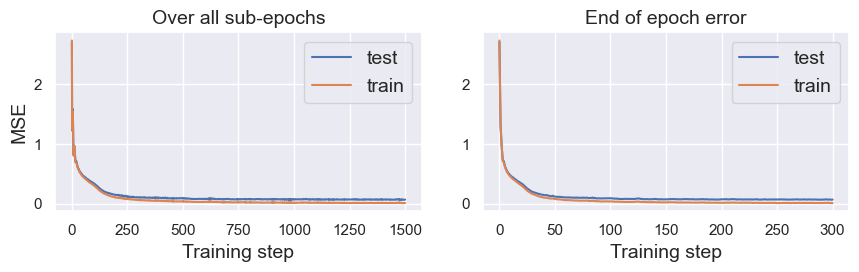

test:  0.96935934
train:  0.9986092


In [27]:
def single_run(X, z, lr, lam, hidden_layer_num, node_per_hidden, hidden_activation, 
               epochs=300, test_index=None, plot_or_not=False):
    
    """
    Performs a training with the given parameter

    Returns result, including the final accuracy scores
    """

    # Initialise beta and create the model
    layer_list = [X.shape[1]] + [node_per_hidden]*hidden_layer_num + [y.shape[1]]
    beta0 = _beta_init(layer_list)
    model = jit(get_neural_network_model(hidden_layer_num ,activation=hidden_activation))

    # Create gradient from loss function. Ridge loss lets us use MSE by lam=0
    loss_func = jit(ridge_loss_method(model=model, lam=lam))
    loss_grad = jit(grad(loss_func))

    # MSE loss function for evaluation
    test_func = jit(MSELoss_method(model))
    # test_func2 = jit(accuracy_method(model))
    test_funcs = [test_func]#, test_func2]

    # Split the dataset.
    X_train, y_train, X_test, y_test, test_index = train_test_split(X, z, 0.2, test_index=test_index)

    # Perform training. We use adam, add the test index
    result = SGD_adam(X_train, y_train, X_test, y_test, grad_method=loss_grad,beta0=beta0, n_epochs=epochs, 
                      test_loss_func= test_funcs, lr=lr)
    result.update({"test_index":test_index, "model":model, "X_test":X_test, "y_test":y_test})

    if plot_or_not:
        plot_test_results(result["test_loss_list"][0], result["train_loss_list"][0], 5, ylabel="MSE")
        # plot_test_results(result["test_loss_list"][1], result["train_loss_list"][1], 5, ylabel="Accuracy")

    # Add accuracy scores
    result["test_accuracy"] = accuracy_method(model)(result["beta_final"], X_test, y_test)
    result["train_accuracy"] = accuracy_method(model)(result["beta_final"], X_train, y_train)

    # Also store the model for later use
    result["model"] = model

    return result

epochs = 300
result = single_run(X, y, lr=0.01, lam=0.0001, hidden_layer_num=2, node_per_hidden=40, 
           hidden_activation=nn.sigmoid, epochs=epochs, test_index=test_index, plot_or_not=True)

print("test: ", result["test_accuracy"])
print("train: ", result["train_accuracy"])

### Architecture

nodes per layer: 1
nodes per layer: 11
nodes per layer: 21
nodes per layer: 31
nodes per layer: 41
nodes per layer: 51


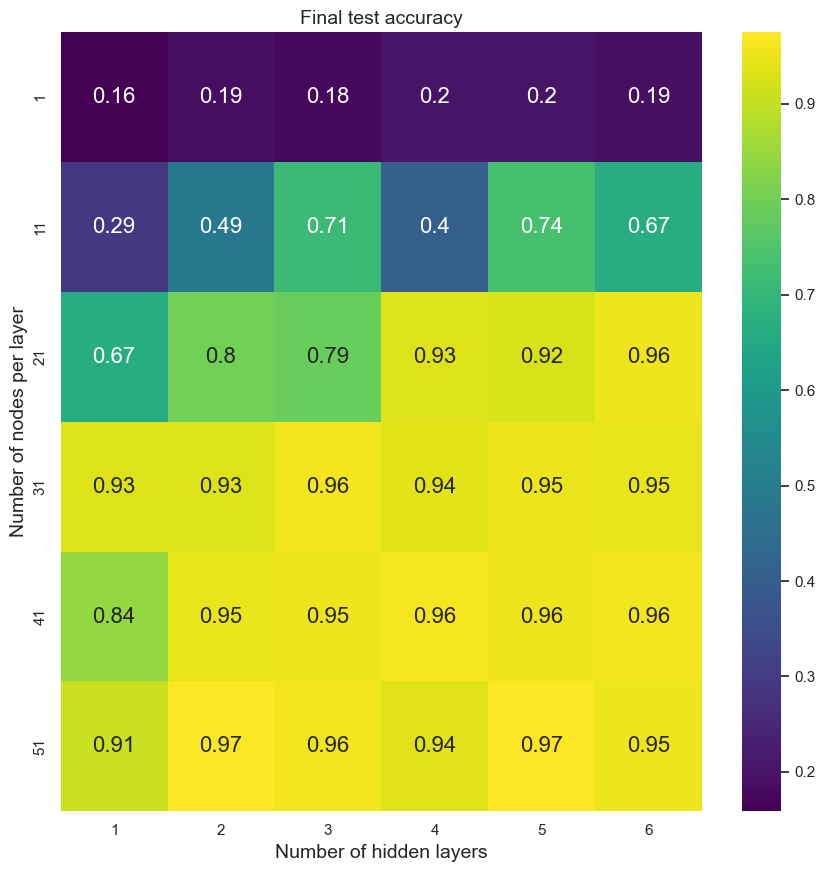

In [18]:
def hidden_node_hidden_layer_grid(savefig=False, nreps=5):
    lam = 1e-5
    lr = 0.01
    hidden_activation = nn.tanh
    hidden_activation_name = "tanh"
    
    # Maximal number of hidden layers and nodes
    n = 6
    # m = 19
    m = 60
    
    filename = filepath_location + f"lr={lr}_lambda={lam}_hidden_activation_func={hidden_activation_name}_nreps={nreps}__hidden_layer_num_grid_experiment_classification.png"

    fig, ax = plt.subplots(figsize=(9, 9))

    hidden_layer_numbers = np.arange(1, n + 1)
    nodes_per_layer_list = np.arange(1, m, m//n)

    # Arrays for storing the errors. temporary result to call result.get
    test_errs_all = np.zeros(shape=(n, n))
    train_errs_all = np.zeros(shape=(n, n))
    result = {}

    # Loop over nodes per layer
    for i, nodes_per_layer in enumerate(nodes_per_layer_list):
        print(f"nodes per layer: {nodes_per_layer}")
        
        # Loop over number of hidden layers
        for j, hidden_layer_number in enumerate(hidden_layer_numbers):
        
            # Accumulation variables for averaging over nreps
            s_test = 0.0
            s_train = 0.0
        
            # Run nreps times 
            for k in range(nreps):
                result = single_run(X, y, lr=lr, lam=lam, hidden_layer_num=hidden_layer_number, 
                                    node_per_hidden=nodes_per_layer, hidden_activation=hidden_activation, 
                                    test_index=result.get("test_index"))
                s_test += result["test_accuracy"]
                s_train += result["train_accuracy"]

            test_errs_all[i, j] = s_test/nreps
            train_errs_all[i, j] = s_train/nreps


    sns.heatmap(test_errs_all, annot=True, ax=ax, cmap="viridis", cbar=True)

    # Title
    ax.set_title("Final test accuracy")

    # Handle labels
    ax.set_xlabel("Number of hidden layers")
    ax.set_ylabel("Number of nodes per layer")

    ax.set_yticklabels(nodes_per_layer_list)
    ax.set_xticklabels(hidden_layer_numbers)
    

    plt.tight_layout()
    if savefig:
        fig.savefig(filename)
    plt.show()

    return {"hidden_layer_sizes":hidden_layer_numbers, "test_error":test_errs_all, "train_error":train_errs_all}

_ = hidden_node_hidden_layer_grid(savefig=True, nreps=1)

### Final model evaluation

We make confusion matrix ...

In [28]:
epochs = 300
result = single_run(X, y, lr=0.01, lam=0.0001, hidden_layer_num=2, node_per_hidden=100, 
           hidden_activation=nn.sigmoid, epochs=epochs, test_index=test_index, plot_or_not=False)

print("test: ", result["test_accuracy"])
print("train: ", result["train_accuracy"])

test:  0.97771585
train:  0.9993046


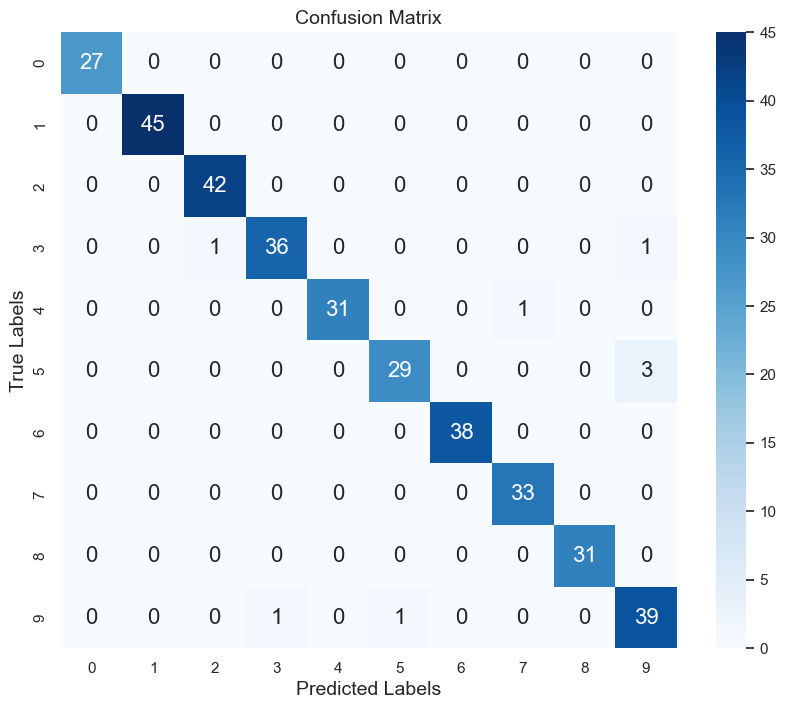

In [32]:
from sklearn.metrics import confusion_matrix

# Example true labels and predicted labels
nums_pred = predict(result["model"], result["beta_final"], X_test)
nums_gt   = jnp.array([jnp.argmax(y_sample) for y_sample in y_test])

# Create confusion matrix
conf_matrix = confusion_matrix(nums_gt, nums_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True,
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Also want to see exactly where the model fails ...

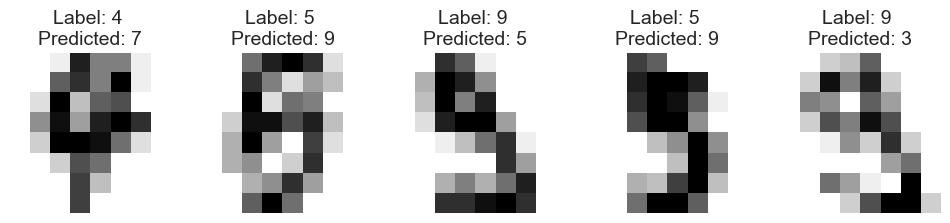

In [37]:
# Format the faulty predictions back
indeces = nums_gt != nums_pred
imgs = [img.reshape(8, 8) for img in X_test[indeces]]
labels_pred = nums_pred[indeces]
labels_gt   = nums_gt[indeces]

# Plot the 5 first
for i, img in enumerate(imgs[0:5]):

    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f"Label: {labels_gt[i]} \nPredicted: {labels_pred[i]}")

plt.show()